# Description

This notebook is for the Kaggle Santander Customer Transaction Prediction Competition in 2019. The object of the competition is to train a model to predict the probability that a customer will make the same transaction again.

Each sample consists of 200 (un-labeled) features describing a transaction. The objective is to do a probability prediction for the binary classification problem of whether the transaction is of class 0 (not repeated) or of class 1 (is repeated).

There are proportionately few transactions that are repeated. So accuracy is a poor measure of our model's success. The metric used to measure success is the Area Under the Receiver Operator Characteristic Curve. This measures the trade off between increasing the true postive rate and increasing the false positive rate.

## Techniques

### Dimension Reduction

The data set has 200 features for each sample and is very large. For space concerns we look at training a transformer to perform dimension reduction using an out-of-core train approach that involves using minibatches of the training data.

To reduce the dimensions of the data, we use a multi-stage process:
1. Scale each feature to be uniform.
2. Find the means of each class.
3. Break data into part along direction of the difference of class means and the part orthogonal to this difference.
4. Find the in-class covariances for each class for the part of the features orthogonal to the mean class difference.
5. Find the directions related to best decomposition of ratios of in-class covariances (technically an eigenvector decomposition of the ratio of the covariances as quadratic forms).
6. Rank the directions by absolute value of logarithm (related to being far above 1.0 or far below 1.0).
7. Keep a certain number of the best directions.
8. Look at the squares of the components.
9. Use logistic regression to find optimal weights to associate to each square, then sum.
10. Final data is two features:
    1. Projection to difference of class means direction.
    2. Weighted sums of best directions.
    
### Final Predictor

After reducing the dimension of the data, we then look at using a final predictor to estimate the probability of repeating a transaction.

Now the largest bottleneck to reading our data will be reading a minibatch from disk, so we split each minibatch for our
cross fold validation as we go. Our dimensionality reduction will depend on the target classes, so we can't separate its training from the cross validation.


## Model Storage

After we are done training our transformers and we have chosen a final predictor, we will store our model in JSON format. In another notebook we will decode the JSON format to a working model and make test predictions.

# Our Module Imports

In [1]:
# Our model source code and helpful classes.

from my_src import my_model # Has the complete dimension reducer/transformer BestDirectionsSquares.
from my_src import my_kfold # For doing kfold validation over out of core mini batch chunks of data.
from my_src import my_json # For doing JSON encoding/decoding for model persistence.
import importlib # For reloading source modules without needing to restart the kernel.

In [2]:
# sklearn imports

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from sklearn.discriminant_analysis import (QuadraticDiscriminantAnalysis,
                                           LinearDiscriminantAnalysis)
from sklearn.tree import (DecisionTreeClassifier,
                          export_graphviz)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [3]:
# Other standard imports.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Extract Target Classes

To do this, we will only be reading one column of the training data. This will fit into memory without problems, so we can
afford to do this in-core in one shot (i.e. no need for mini batch chunks).

In [4]:
# Get the target classes.

y = pd.read_csv('data/train.csv', index_col = 'ID_code', usecols = ['ID_code', 'target'])
y = y['target'] # Convert to pd.Series

# Check the head of the series to make sure everything looks okay.
y.head()

ID_code
train_0    0
train_1    0
train_2    0
train_3    0
train_4    0
Name: target, dtype: int64

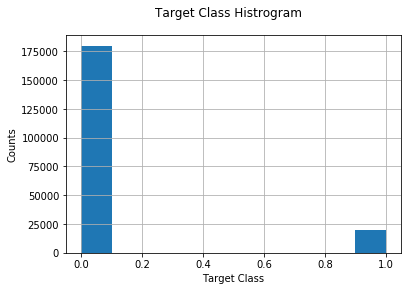

In [5]:
# Make a histogram of the targets.

y.hist()
plt.xlabel('Target Class')
plt.ylabel('Counts')
plt.suptitle('Target Class Histrogram')
plt.show()

We see that there are far fewer points in class 1 than class 0. This class imbalance leads us to see that the Area Under the Receiver Operator Curve is a much better metric for our model than accuracy.

# Get the Kfold Splits we will be Using for Validation

Since the dataset is so large (in particular since there are 200 features), we will be doing training out of core. That is, we will use mini batch chunks of the data to train a transformer to reduce the dimension to something that will fit comfortably in memory.

For consistency of doing kfold-validation on the chunks, we will get plan for doing kfold validation of each chunk.

In [6]:
chunk_size = 2 * 10**4

In [7]:
# Find the indices and splits we will need for our k-fold validation.

kfold = 5
splitter = StratifiedShuffleSplit(kfold, random_state = np.random.RandomState(1))
split_chunks = my_kfold.SplitReaderIndices('data/train.csv', index_col = 'ID_code', chunk_size = chunk_size)

Splitting chunks: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

# Build Dimension Reducer

Let's build the kfold-validation of the dimension reducer. We use an instance of my_model.BestDirectionsSquares for each fold to do the dimension reduction.

In [8]:
# Initialize the dimension reducer for each fold of cross-validation.

kfold_preprocess = [my_model.BestDirectionsSquares() for _ in range(kfold)]

In [9]:
# Train the scaler, in-class means, and the in-class covariance of part orthogonal to mean difference direction.

for sub_model in ['scaler', 'class_means', 'class_cov']:
    print('Training ' + sub_model + '\'s')
    for i, splits in enumerate(split_chunks):
        print('Chunk', i, end = '')
        for split, transformer in zip(splits, kfold_preprocess):
            print('.', end = '')
            X_train, _, y_train, _ = split
            transformer.partial_fit(sub_model, X_train, y_train)
        print(end = ', ')
    print(sub_model + '\'s finished training')

Training scaler's
Chunk 0....., Chunk 1....., Chunk 2....., Chunk 3....., Chunk 4....., Chunk 5....., Chunk 6....., Chunk 7....., Chunk 8....., Chunk 9....., scaler's finished training
Training class_means's
Chunk 0....., Chunk 1....., Chunk 2....., Chunk 3....., Chunk 4....., Chunk 5....., Chunk 6....., Chunk 7....., Chunk 8....., Chunk 9....., class_means's finished training
Training class_cov's
Chunk 0....., Chunk 1....., Chunk 2....., Chunk 3....., Chunk 4....., Chunk 5....., Chunk 6....., Chunk 7....., Chunk 8....., Chunk 9....., class_cov's finished training


In [10]:
# Fit the best in-class covariance ratio directions.

for transformer in kfold_preprocess:
    transformer.fit_directions()

In [11]:
# Reduce dimensions of train and test splits to a certain number of best ratio directions for each fold of the cross-validation.

kfold_X_reduced = [{'train' : [], 'test' : []} for _ in kfold_preprocess]
for i, splits in enumerate(split_chunks):
        print('Chunk', i, end = '')
        for split, transformer, X_reduced in zip(splits, kfold_preprocess, kfold_X_reduced):
            print('.', end = '')
            X_train, X_test, _, _ = split
            X_new = transformer.reduce_directions(X_train)
            X_reduced['train'].append(X_new)
            
            X_new = transformer.reduce_directions(X_test)
            X_reduced['test'].append(X_new)
        print(end = ', ')

Chunk 0....., Chunk 1....., Chunk 2....., Chunk 3....., Chunk 4....., Chunk 5....., Chunk 6....., Chunk 7....., Chunk 8....., Chunk 9....., 

In [12]:
# Concatenate reduced data into a pandas.DataFrame for each fold of the cross-validation.

for X_reduced in kfold_X_reduced:
    for key in X_reduced:
        X_reduced[key] = pd.concat(X_reduced[key], axis = 0)

In [13]:
# Fit the weights of each direction feature for when computing the squares.

for transformer, X_reduced in zip(kfold_preprocess, kfold_X_reduced):
    for key in X_reduced:
        transformer.fit_squares(X_reduced[key], y[X_reduced[key].index])

In [14]:
# Reduce to mean difference features and weighted sum of squares of ratio directions features.

kfold_X_squares = [{'train' : [], 'test' : []} for _ in kfold_X_reduced]
for transformer, X_reduced, X_squares in zip(kfold_preprocess, kfold_X_reduced, kfold_X_squares):
    for key in X_reduced.keys():
        X_squares[key] = transformer.reduce_squares(X_reduced[key])

# Look at Difference in Class Means

Let's plot the difference in class means for one of the folds.

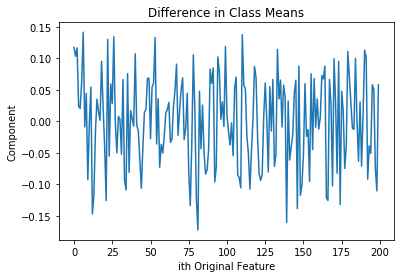

In [15]:
difference_dir = kfold_preprocess[0].sub_models['class_means'].get_difference_direction().reshape(-1)
plt.plot(difference_dir)
plt.xlabel('ith Original Feature')
plt.ylabel('Component')
plt.title('Difference in Class Means')
plt.show()

# Look at Best Directions and Weights

Now, let's take a look at the best directions ratios and the weights used in our weighted sum of squares.

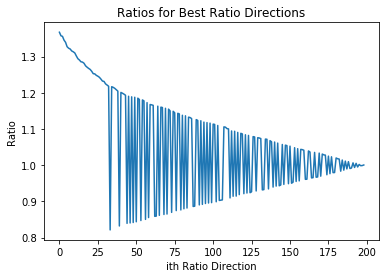

In [16]:
# Graph the ratios, ordered by rank.

directions = kfold_preprocess[0].sub_models['ratio_directions']
plt.plot(directions.ratios)
plt.xlabel('ith Ratio Direction')
plt.ylabel('Ratio')
plt.title('Ratios for Best Ratio Directions')
plt.show()


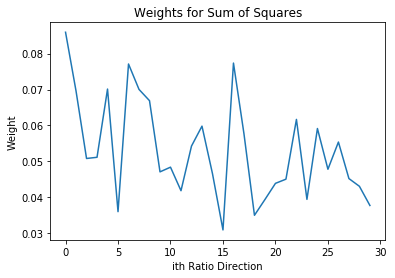

In [17]:
weights = kfold_preprocess[0].sub_models['weight_predictor']
plt.plot(weights.coef_.reshape(-1))
plt.xlabel('ith Ratio Direction')
plt.ylabel('Weight')
plt.title('Weights for Sum of Squares')
plt.show()

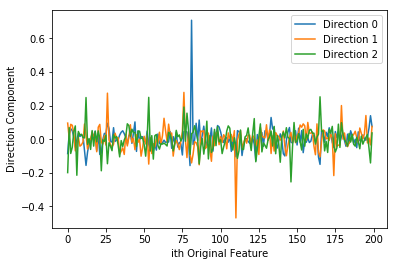

In [18]:
plt.plot(directions.directions[:3].T)
plt.xlabel('ith Original Feature')
plt.ylabel('Direction Component')
plt.legend(['Direction ' + str(i) for i in range(3)])
plt.show()

# Look at Reduced Features

Let's plot the distributions of the reduced features for one of the folds of our cross validation.

In [19]:
def graph_in_class_distribution(feature, X, y):
    for target in [0, 1]:
        on_target = y.loc[X.index] == target
        sns.distplot(X.loc[on_target, feature])
    plt.legend(['class ' + str(i) for i in range(2)])
    plt.xlabel('Reduced Feature ' + str(feature))
    plt.ylabel('In-class Proportion')
    
# For large data, it is convenient to graph a sample drawn from the data.

def graph2d_in_class_distribution(features, X, y, sample_size = 10**4):

    for target in [0, 1]:
        on_target = y.loc[X.index] == target
        if sample_size is None:
            data = X.loc[on_target, features]
        else:
            data = X.loc[on_target, features].sample(sample_size)
        sns.kdeplot(data[features[0]], data[features[1]], shade_lowest = False)
    plt.legend(['class ' + str(i) for i in range(2)])
    plt.xlabel('Reduced Feature ' + str(features[0]))
    plt.ylabel('Reduced Feature ' + str(features[1]))
    

c:\users\matthew\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


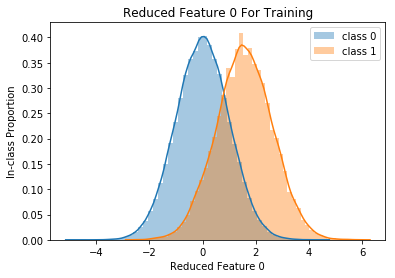

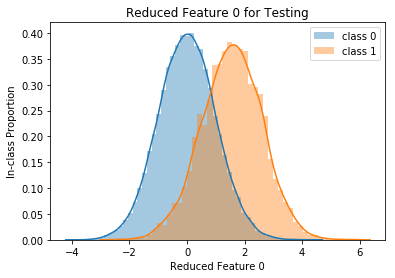

In [20]:
graph_in_class_distribution(0, kfold_X_squares[0]['train'], y)
plt.title('Reduced Feature 0 For Training')
plt.show()

graph_in_class_distribution(0, kfold_X_squares[0]['test'], y)
plt.title('Reduced Feature 0 for Testing')
plt.show()

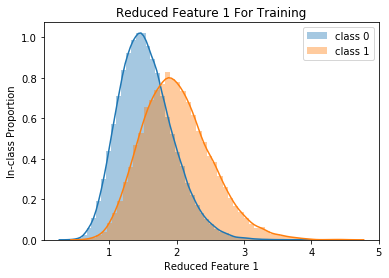

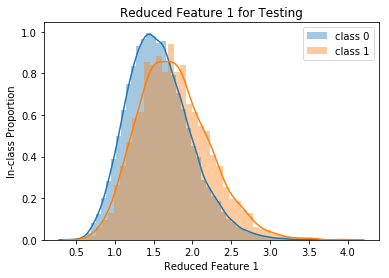

In [21]:
graph_in_class_distribution(1, kfold_X_squares[0]['train'], y)
plt.title('Reduced Feature 1 For Training')
plt.show()

graph_in_class_distribution(1, kfold_X_squares[0]['test'], y)
plt.title('Reduced Feature 1 for Testing')
plt.show()

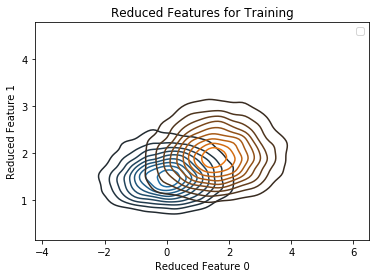

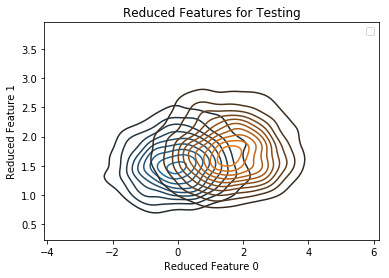

In [22]:
# Graph 2d-distributions of reduced features.

graph2d_in_class_distribution([0, 1], kfold_X_squares[0]['train'], y)
plt.title('Reduced Features for Training')
plt.show()

graph2d_in_class_distribution([0, 1], kfold_X_squares[0]['test'], y, sample_size = 3 * 10**3)
plt.title('Reduced Features for Testing')
plt.show()

# Find a Final Predictor Using Cross Validation

Use our cross validation folds to find the best final predictor.

In [23]:
# Try a simple linear discriminant predictor.

scores = my_kfold.do_kfold_cv(kfold_X_squares, y, LinearDiscriminantAnalysis(), score = roc_auc_score)
print(scores.mean())
scores

fold 0, fold 1, fold 2, fold 3, fold 4, 0.8528930387647626


array([0.85270713, 0.85010478, 0.8495088 , 0.85338467, 0.85875982])

In [24]:
# Let's do CV on number of neighbors in k-nearest neightbors.

params = np.arange(3, 60, 10)
all_scores = []
for param in params:
    print('k-nbrs = ', param, end = ',\t')
    scores = my_kfold.do_kfold_cv(kfold_X_squares, y, KNeighborsClassifier(param), score = roc_auc_score)
    all_scores.append(scores)
    print(scores)
all_scores = np.array(all_scores)

k-nbrs =  3,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.72468517 0.71831714 0.72119287 0.72828217 0.73054754]
k-nbrs =  13,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.80678201 0.80282046 0.80525811 0.80707991 0.81217202]
k-nbrs =  23,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.82219094 0.81890424 0.82548584 0.82492464 0.83046257]
k-nbrs =  33,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.83213804 0.82919713 0.83125781 0.83390671 0.83760057]
k-nbrs =  43,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.83649371 0.83438973 0.83620062 0.8383295  0.84299646]
k-nbrs =  53,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.83972911 0.83811808 0.83821133 0.84086051 0.8470073 ]


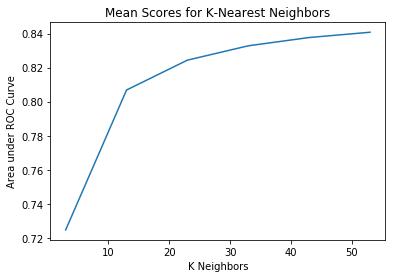

In [25]:
all_scores = np.array(all_scores)
plt.plot(params, all_scores.mean(axis = -1))
plt.xlabel('K Neighbors')
plt.ylabel('Area under ROC Curve')
plt.title('Mean Scores for K-Nearest Neighbors')
plt.show()

In [26]:
# Let's do CV on polynomial features.

params = np.arange(1, 4, 1)
all_scores = []
for param in params:
    print('degree = ', param, end = ',\t')
    kfold_X_new = []
    for X in kfold_X_squares:
        
        X_new = {key : PolynomialFeatures(param, include_bias = False, interaction_only = False).fit_transform(X[key]) for key in X.keys()}
        X_new = {key : pd.DataFrame(X_new[key], index = X[key].index) for key in X.keys()}
        kfold_X_new.append(X_new)
        
    scores = my_kfold.do_kfold_cv(kfold_X_new, y, LogisticRegression(solver = 'lbfgs', max_iter = 300), score = roc_auc_score)
    all_scores.append(scores)
    print(scores)
all_scores = np.array(all_scores)

degree =  1,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.85842961 0.85528631 0.85464701 0.8592712  0.86414839]
degree =  2,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.85721373 0.85449932 0.85368554 0.8581477  0.86295853]
degree =  3,	fold 0, fold 1, fold 2, fold 3, fold 4, [0.85736228 0.85457922 0.85382873 0.85817739 0.86303659]


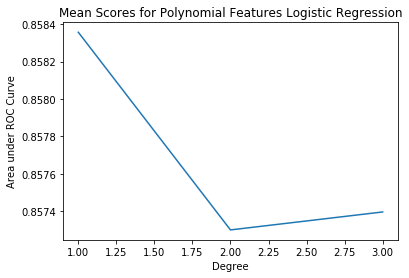

In [27]:
all_scores = np.array(all_scores)
plt.plot(params, all_scores.mean(axis = -1))
plt.xlabel('Degree')
plt.ylabel('Area under ROC Curve')
plt.title('Mean Scores for Polynomial Features Logistic Regression')
plt.show()

In [28]:
scores = my_kfold.do_kfold_cv(kfold_X_squares, y, QuadraticDiscriminantAnalysis(), score = roc_auc_score)
print(scores.mean())
scores

fold 0, fold 1, fold 2, fold 3, fold 4, 0.8559510757300768


array([0.85701695, 0.85185638, 0.85197397, 0.85666141, 0.86224667])

In [29]:
params = 10**np.linspace(-5, -4, 5)
all_scores = []
for param in params:
    scores = my_kfold.do_kfold_cv(kfold_X_squares, y, DecisionTreeClassifier(min_impurity_decrease = param), score = roc_auc_score)
    print(scores)
    all_scores.append(scores)

fold 0, fold 1, fold 2, fold 3, fold 4, [0.84218635 0.84307514 0.84232358 0.84261799 0.84832915]
fold 0, fold 1, fold 2, fold 3, fold 4, [0.85134093 0.84855033 0.84686046 0.85320191 0.85541043]
fold 0, fold 1, fold 2, fold 3, fold 4, [0.85169654 0.8489271  0.84718072 0.84864191 0.85578725]
fold 0, fold 1, fold 2, fold 3, fold 4, [0.84995611 0.84361854 0.84327761 0.84847777 0.85484606]
fold 0, fold 1, fold 2, fold 3, fold 4, [0.84832298 0.83897546 0.84352136 0.84285525 0.84954772]


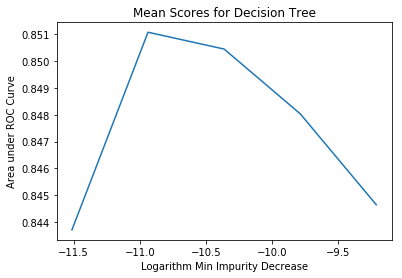

In [30]:
all_scores = np.array(all_scores)
plt.plot(np.log(params), all_scores.mean(axis = -1))
plt.xlabel('Logarithm Min Impurity Decrease')
plt.ylabel('Area under ROC Curve')
plt.title('Mean Scores for Decision Tree')
plt.show()

# Make Final Model

For the final predictor, a simple linear discriminant predictor performs very similar to everything else. So we will pick a simple linear discriminator. 

Now let us retrain on the entire training set.

In [31]:
# Fit the dimension reducer to the training set.

final_preprocess = my_model.BestDirectionsSquares()
final_preprocess.fit_chunks('data/train.csv', index_col = 'ID_code', chunk_size = chunk_size)

Training scaler's
Chunk 0, Chunk 1, Chunk 2, Chunk 3, Chunk 4, Chunk 5, Chunk 6, Chunk 7, Chunk 8, Chunk 9, scaler's finished training
Training class_means's
Chunk 0, Chunk 1, Chunk 2, Chunk 3, Chunk 4, Chunk 5, Chunk 6, Chunk 7, Chunk 8, Chunk 9, class_means's finished training
Training class_cov's
Chunk 0, Chunk 1, Chunk 2, Chunk 3, Chunk 4, Chunk 5, Chunk 6, Chunk 7, Chunk 8, Chunk 9, class_cov's finished training
Fitting directions
Reducing to directions
Chunk 0, Chunk 1, Chunk 2, Chunk 3, Chunk 4, Chunk 5, Chunk 6, Chunk 7, Chunk 8, Chunk 9, 

In [32]:
# Reduce the training set.

reader = pd.read_csv('data/train.csv', index_col = 'ID_code', chunksize = chunk_size)
final_X_squares = []
for i, df in enumerate(reader):
    print('Chunk', i, end = ', ')
    X_train = df.drop('target', axis = 1)
    X_squares = final_preprocess.transform(X_train)
    final_X_squares.append(X_squares)
final_X_squares = pd.concat(final_X_squares)

Chunk 0, Chunk 1, Chunk 2, Chunk 3, Chunk 4, Chunk 5, Chunk 6, Chunk 7, Chunk 8, Chunk 9, 

In [33]:
# Train the final predictor.

final_predictor = LinearDiscriminantAnalysis()
final_predictor.fit(final_X_squares, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [34]:
# Check out the training error to double check our model.

y_predict = final_predictor.predict_proba(final_X_squares)[:, 1]
roc_auc_score(y, y_predict)

0.8953335023516895

The trainig error looks good. NOTE, the training error is overly optimistic. The testing error should be closer to the cross-validation scores.

## Write a JSON Encoding of the Model to File

Now let's make a JSON encoding of the final model and save it to file. That way we can use the model in the future without needing to retrain it.

In [35]:
# Write the JSON version of model to file.

final_model = {'preprocess' : final_preprocess, 
               'predictor' : final_predictor}
json_model = json.dumps(final_model, cls = my_json.MyModelEncoder)